# Genomics Laboratory
## Teacher's Solution Notebook

This notebook contains fully solved exercises for the Genomics laboratory session. Each exercise demonstrates practical bioinformatics analysis using real biological data and APIs.

**Learning Objectives:**
- Retrieve genomic data from public databases using REST APIs
- Analyze DNA sequences and compute basic statistics
- Work with genetic variants and their annotations
- Integrate multi-omics data (genomics, epigenomics)
- Design CRISPR guide RNAs
- Model gene expression dynamics using ODEs

---

## Laboratory Pipeline Overview

This laboratory session follows a complete bioinformatics analysis pipeline:

1. **Exercise 1: Retrieve Gene Sequence**
   - Fetch genomic sequence from Ensembl REST API
   - Compute basic sequence statistics (GC content, CpG motifs, length)
   - Visualize GC content along the sequence

2. **Exercise 2: Fetch Variants**
   - Retrieve known genetic variants (SNPs/INDELs) from Ensembl Variation API
   - Plot variant distribution along the gene
   - Annotate variant impact

3. **Exercise 3: Fetch Methylation Data**
   - Query ENCODE database for whole-genome bisulfite sequencing (WGBS) data
   - Understand epigenomic datasets

4. **Exercise 4: Merge Variant + Methylation Data**
   - Integrate variant positions with methylation scores
   - Identify regulatory SNPs (variants in high-methylation zones)

5. **Exercise 5: CRISPR Guide Design**
   - Identify PAM sites (NGG) for SpCas9
   - Design and score guide RNAs using heuristics

6. **Exercise 6: Synthetic Gene Circuit Simulation**
   - Model gene expression using ordinary differential equations (ODEs)
   - Simulate dynamic behavior of gene circuits


In [1]:
# Import required libraries
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import solve_ivp
import os

# Configure plotting
plt.style.use('seaborn-v0_8')

# Set up output directory
output_dir = "lab_outputs"
os.makedirs(output_dir, exist_ok=True)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Exercise 1: Retrieve Gene Sequence Using an API

**Goal:** Teach API usage, JSON parsing, and basic bioinformatics manipulation.

**Background:** The Ensembl REST API provides programmatic access to genomic data including DNA sequences, gene annotations, and variant information. This exercise introduces you to working with REST APIs in bioinformatics.

**Task:**
1. Use Ensembl REST API to download the genomic sequence of a chosen gene (e.g., TP53, BRCA1, or TERT)
2. Store the sequence as FASTA format
3. Compute basic statistics:
   - GC content (overall and using sliding window)
   - Number of CpG motifs
   - Sequence length
4. Plot GC-content along the sequence using a sliding window

**Key Concepts:**
- REST API usage for biological databases
- JSON parsing and data extraction
- DNA sequence analysis
- Sliding window operations
- FASTA file format

**Useful Ensembl Gene IDs:**
- TP53: `ENSG00000141510`
- BRCA1: `ENSG00000012048`
- TERT: `ENSG00000164362`


In [2]:
# Implement fetch_gene_sequence_ensembl function
def fetch_gene_sequence_ensembl(gene_id):
    """
    Fetch DNA sequence for a given human gene using Ensembl REST API.
    
    Parameters:
    - gene_id (str): Ensembl gene ID (e.g., "ENSG00000141510" for TP53)
    
    Returns:
    - str: Gene sequence in uppercase A/C/G/T
    """
    url = f"https://rest.ensembl.org/sequence/id/{gene_id}?content-type=application/json"
    response = requests.get(url)
    
    if not response.ok:
        raise Exception(f"Failed to fetch sequence for {gene_id}")
    
    data = response.json()
    seq = data.get("seq", "").upper()
    
    return seq


In [3]:
# Exercise 1: Retrieve Gene Sequence
print("=" * 60)
print("Exercise 1: Retrieve Gene Sequence Using Ensembl API")
print("=" * 60)

# Choose a gene to analyze
# Options: TP53 (ENSG00000141510), BRCA1 (ENSG00000012048), TERT (ENSG00000164362)
gene_id = "ENSG00000141510"  # TP53
gene_name = "TP53"

print(f"\nFetching sequence for {gene_name} ({gene_id})...")

try:
    # Fetch the gene sequence using fetch_gene_sequence_ensembl
    sequence = fetch_gene_sequence_ensembl(gene_id)
    
    print(f"✓ Successfully retrieved sequence")
    print(f"  Sequence length: {len(sequence):,} bp")
    print(f"  First 50 bases: {sequence[:50]}")
    
except Exception as e:
    print(f"✗ Error fetching sequence: {e}")
    sequence = None


Exercise 1: Retrieve Gene Sequence Using Ensembl API

Fetching sequence for TP53 (ENSG00000141510)...
✓ Successfully retrieved sequence
  Sequence length: 25,768 bp
  First 50 bases: GGATTGGGGTTTTCCCCTCCCATGTGCTCAAGACTGGCGCTAAAAGTTTT


In [4]:
# Store sequence as FASTA format
if sequence is not None:
    # Create FASTA format string
    # FASTA format: first line starts with ">", followed by description
    # Subsequent lines contain the sequence (typically 60-80 characters per line)
    fasta_header = f">{gene_id} {gene_name}"
    
    # Format sequence with line breaks (every 60 characters)
    fasta_sequence = "\n".join([sequence[i:i+60] for i in range(0, len(sequence), 60)])
    fasta_content = f"{fasta_header}\n{fasta_sequence}\n"
    
    # Save to file
    fasta_filename = f"{output_dir}/{gene_name}_sequence.fasta"
    with open(fasta_filename, 'w') as f:
        f.write(fasta_content)
    
    print(f"✓ Sequence saved to {fasta_filename}")
    print(f"\nFASTA preview:")
    print(fasta_content[:200] + "..." if len(fasta_content) > 200 else fasta_content)
else:
    print("⚠ No sequence available to save")


✓ Sequence saved to lab_outputs/TP53_sequence.fasta

FASTA preview:
>ENSG00000141510 TP53
GGATTGGGGTTTTCCCCTCCCATGTGCTCAAGACTGGCGCTAAAAGTTTTGAGCTTCTCA
AAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCGGGGACACTTTGCGT
TCGGGCTGGGAGCGTGCTTTCCACGACGGTGACACGCTTCCCTGGATTGGGTAAGC...


In [8]:
# Compute basic sequence statistics
if sequence is not None:
    print("\n" + "=" * 60)
    print("Basic Sequence Statistics")
    print("=" * 60)
    
    # Calculate sequence length
    seq_length = len(sequence)
    
    # Calculate overall GC content
    # GC content = (G + C) / total_length
    g_count = sequence.count("G")
    c_count = sequence.count("C")
    gc_count = g_count + c_count
    gc_content = gc_count / seq_length if seq_length > 0 else 0
    
    # Count CpG motifs
    # CpG motif = "CG" dinucleotide
    cpg_count = sequence.count("CG")
    cpg_density = (cpg_count / seq_length) * 1000 if seq_length > 0 else 0
    
    # Count each nucleotide
    a_count = sequence.count("A")
    t_count = sequence.count("T")
    
    # Print statistics
    print(f"\nSequence Statistics for {gene_name}:")
    print(f"  Length: {seq_length:,} bp")
    print(f"  GC content: {gc_content:.2%}")
    print(f"  CpG motifs: {cpg_count:,}")
    print(f"  CpG density: {cpg_density:.2f} per 1000 bp")
    print(f"\nNucleotide composition:")
    print(f"  A: {a_count:,} ({a_count/seq_length:.2%})")
    print(f"  T: {t_count:,} ({t_count/seq_length:.2%})")
    print(f"  G: {g_count:,} ({g_count/seq_length:.2%})")
    print(f"  C: {c_count:,} ({c_count/seq_length:.2%})")
else:
    print("⚠ No sequence available for analysis")



Basic Sequence Statistics

Sequence Statistics for TP53:
  Length: 25,768 bp
  GC content: 48.86%
  CpG motifs: 533
  CpG density: 20.68 per 1000 bp

Nucleotide composition:
  A: 6,832 (26.51%)
  T: 6,346 (24.63%)
  G: 6,392 (24.81%)
  C: 6,198 (24.05%)


In [9]:
# Implement compute_gc_content function
def compute_gc_content(sequence, window=200):
    """
    Compute GC-content using a sliding window across the sequence.
    
    Parameters:
    - sequence (str): DNA sequence
    - window (int): Window size for sliding window
    
    Returns:
    - pandas.DataFrame: Columns ['start', 'end', 'gc_content']
    
    Algorithm:
    1. Slide a window of size 'window' along the sequence
    2. For each window, calculate GC content = (G + C) / window_size
    3. Store start position, end position, and GC content
    """
    results = []
    seq_len = len(sequence)
    
    # Implement sliding window
    # Loop through sequence with step size = window
    for i in range(0, seq_len - window + 1, window):
        window_seq = sequence[i:i+window]
        gc = (window_seq.count("G") + window_seq.count("C")) / window
        results.append([i, i+window, gc])
    
    # Create DataFrame
    df_gc = pd.DataFrame(results, columns=['start', 'end', 'gc_content'])
    
    return df_gc


In [6]:
# Compute GC content using sliding window
if sequence is not None:
    print("\n" + "=" * 60)
    print("Computing GC Content with Sliding Window")
    print("=" * 60)
    
    # Set window size
    window_size = 200  # 200 bp windows
    
    # Compute GC content using compute_gc_content function
    df_gc = compute_gc_content(sequence, window=window_size)
    
    print(f"✓ Computed GC content for {len(df_gc)} windows")
    print(f"\nFirst 5 windows:")
    print(df_gc.head())
else:
    print("⚠ No sequence available for GC content analysis")



Computing GC Content with Sliding Window
✓ Computed GC content for 128 windows

First 5 windows:
   start   end  gc_content
0      0   200       0.565
1    200   400       0.555
2    400   600       0.485
3    600   800       0.575
4    800  1000       0.525



Visualizing GC Content Along Gene


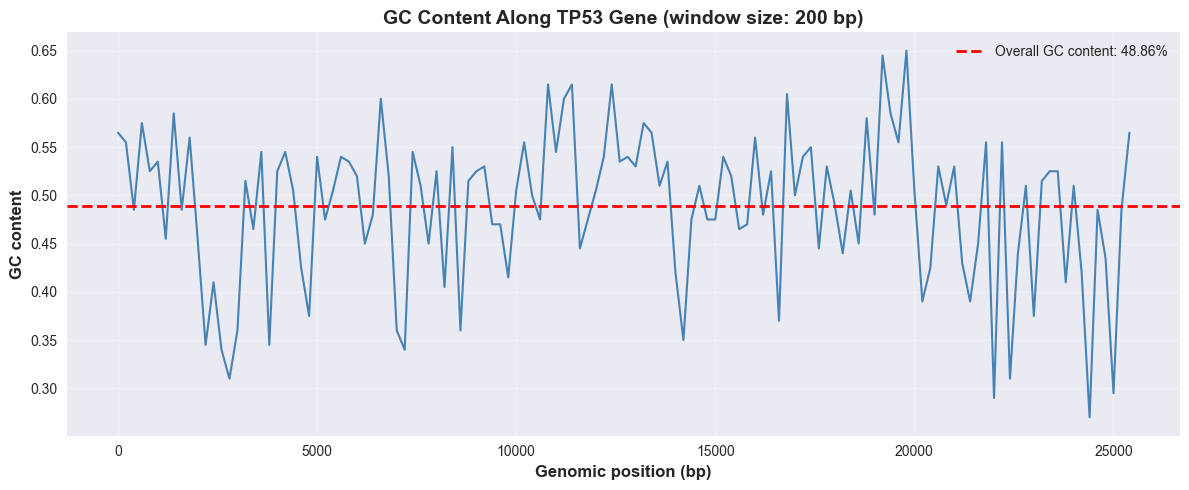


GC Content Statistics:
  Mean: 0.488
  Median: 0.505
  Min: 0.270
  Max: 0.650
  Std Dev: 0.078


In [10]:
# Plot GC content along the sequence
if sequence is not None and 'df_gc' in locals() and df_gc is not None:
    print("\n" + "=" * 60)
    print("Visualizing GC Content Along Gene")
    print("=" * 60)
    
    # Create plot
    plt.figure(figsize=(12, 5))
    
    # Plot GC content
    plt.plot(df_gc['start'], df_gc['gc_content'], linewidth=1.5, color='steelblue')
    
    # Add labels and title
    plt.xlabel("Genomic position (bp)", fontsize=12, fontweight='bold')
    plt.ylabel("GC content", fontsize=12, fontweight='bold')
    plt.title(f"GC Content Along {gene_name} Gene (window size: {window_size} bp)", 
              fontsize=14, fontweight='bold')
    
    # Add horizontal line for overall GC content
    plt.axhline(y=gc_content, color='red', linestyle='--', linewidth=2, 
                label=f'Overall GC content: {gc_content:.2%}')
    plt.legend()
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nGC Content Statistics:")
    print(f"  Mean: {df_gc['gc_content'].mean():.3f}")
    print(f"  Median: {df_gc['gc_content'].median():.3f}")
    print(f"  Min: {df_gc['gc_content'].min():.3f}")
    print(f"  Max: {df_gc['gc_content'].max():.3f}")
    print(f"  Std Dev: {df_gc['gc_content'].std():.3f}")
else:
    print("⚠ No GC content data available for plotting")


## Exercise 2: Fetch and Analyze Known Variants

**Goal:** Introduce variant data, annotation, and visualization.

**Background:** Genetic variants (SNPs, INDELs) are differences in DNA sequence between individuals. Understanding where variants occur and their functional impact is crucial for understanding disease mechanisms and personalized medicine. The Ensembl Variation API provides access to annotated variants from multiple sources.

**Task:**
1. Use Ensembl Variation API to fetch all SNPs for the gene
2. Filter SNPs by:
   - Location within promoter region (−1000 bp from gene start)
   - Coding region
   - High-impact variants (missense, nonsense)
3. Plot:
   - Histogram of variant density along the gene
   - Scatter plot of variant impact score vs. genomic position

**Key Concepts:**
- Variant annotation and consequence types
- Promoter regions and regulatory elements
- Coding vs. non-coding variants
- Variant impact classification
- Data filtering and visualization


In [11]:
# Implement fetch_variants_for_gene function
def fetch_variants_for_gene(gene_id):
    """
    Retrieve SNPs/INDELs for a given gene using Ensembl Variation API.
    
    Parameters:
    - gene_id (str): Ensembl gene ID
    
    Returns:
    - DataFrame: Variation table with columns:
        ['id', 'start', 'end', 'alleles', 'consequence_type']
    """
    url = f"https://rest.ensembl.org/overlap/id/{gene_id}?feature=variation;content-type=application/json"
    response = requests.get(url)
    
    if not response.ok:
        raise Exception(f"Failed to fetch variants for {gene_id}")
    
    data = response.json()
    
    rows = []
    for var in data:
        rows.append([
            var.get('id'),
            var.get('start'),
            var.get('end'),
            var.get('alleles'),
            var.get('consequence_type')
        ])
    
    return pd.DataFrame(rows, columns=['id', 'start', 'end', 'alleles', 'consequence_type'])


In [12]:
# Exercise 2: Fetch and Analyze Known Variants
print("=" * 60)
print("Exercise 2: Fetch and Analyze Known Variants")
print("=" * 60)

# Check if we have the gene sequence from Exercise 1
if 'sequence' not in locals() or sequence is None:
    print("⚠ Warning: Gene sequence not found. Please run Exercise 1 first.")
    # Re-fetch if needed
    if 'gene_id' in locals():
        sequence = fetch_gene_sequence_ensembl(gene_id)
        print(f"✓ Fetched sequence for variant analysis")
    else:
        print("✗ Cannot proceed without gene information")
        df_variants = None
else:
    # Get gene start position (we'll use position 0 as reference, or fetch gene info)
    # For simplicity, we'll use the sequence start as gene start
    # In practice, you'd fetch gene coordinates from Ensembl
    gene_start = 0  # Relative to sequence start
    
    print(f"\nFetching variants for {gene_name} ({gene_id})...")
    
    try:
        # Fetch variants using Ensembl Variation API
        df_variants = fetch_variants_for_gene(gene_id)
        
        print(f"✓ Retrieved {len(df_variants)} variants")
        
        if len(df_variants) > 0:
            # Convert start/end to numeric if needed
            df_variants['start'] = pd.to_numeric(df_variants['start'], errors='coerce')
            df_variants['end'] = pd.to_numeric(df_variants['end'], errors='coerce')
            
            # Remove rows with invalid positions
            df_variants = df_variants.dropna(subset=['start', 'end'])
            
            print(f"  Valid variants: {len(df_variants)}")
            print(f"\nFirst 5 variants:")
            print(df_variants.head())
            
            # Display variant statistics
            print(f"\nVariant Statistics:")
            print(f"  Total variants: {len(df_variants)}")
            if 'consequence_type' in df_variants.columns:
                print(f"\nConsequence types:")
                consequence_counts = df_variants['consequence_type'].value_counts()
                for cons, count in consequence_counts.head(10).items():
                    print(f"    {cons}: {count}")
        else:
            print("⚠ No variants found for this gene")
            
    except Exception as e:
        print(f"✗ Error fetching variants: {e}")
        df_variants = None


Exercise 2: Fetch and Analyze Known Variants

Fetching variants for TP53 (ENSG00000141510)...
✓ Retrieved 12757 variants
  Valid variants: 12757

First 5 variants:
             id    start      end     alleles    consequence_type
0  rs1160905233  7661784  7661787  [AGAG, AG]  intergenic_variant
1  rs2072688722  7661787  7661787      [G, A]  intergenic_variant
2  rs1597338658  7661793  7661793      [C, T]  intergenic_variant
3  rs2072688750  7661798  7661798      [T, C]  intergenic_variant
4  rs1039515440  7661799  7661799      [T, G]  intergenic_variant

Variant Statistics:
  Total variants: 12757

Consequence types:
    intron_variant: 6304
    intergenic_variant: 2692
    3_prime_UTR_variant: 846
    missense_variant: 844
    5_prime_UTR_variant: 597
    frameshift_variant: 322
    coding_sequence_variant: 309
    synonymous_variant: 195
    splice_region_variant: 127
    stop_gained: 104


In [13]:
# Filter variants by location and impact
if df_variants is not None and len(df_variants) > 0:
    print("\n" + "=" * 60)
    print("Filtering Variants")
    print("=" * 60)
    
    # Get sequence length for reference
    seq_length = len(sequence) if 'sequence' in locals() else 0
    
    # Filter 1: Promoter region (-1000 bp from gene start)
    # Note: We'll use the minimum start position as gene start reference
    min_start = df_variants['start'].min()
    promoter_start = min_start - 1000
    promoter_end = min_start
    
    df_promoter = df_variants[
        (df_variants['start'] >= promoter_start) & 
        (df_variants['start'] <= promoter_end)
    ].copy()
    
    print(f"\n1. Promoter region variants (-1000 bp from gene start):")
    print(f"   Found {len(df_promoter)} variants in promoter region")
    if len(df_promoter) > 0:
        print(f"   Position range: {df_promoter['start'].min():,} - {df_promoter['start'].max():,} bp")
    
    # Filter 2: Coding region variants
    # High-impact variants typically affect coding sequences
    # We'll identify variants with coding-related consequences
    coding_consequences = [
        'missense_variant', 'nonsense_variant', 'synonymous_variant',
        'stop_gained', 'stop_lost', 'start_lost', 'frameshift_variant',
        'inframe_insertion', 'inframe_deletion', 'protein_altering_variant'
    ]
    
    df_coding = df_variants[
        df_variants['consequence_type'].isin(coding_consequences)
    ].copy()
    
    print(f"\n2. Coding region variants:")
    print(f"   Found {len(df_coding)} variants in coding regions")
    if len(df_coding) > 0:
        print(f"   Position range: {df_coding['start'].min():,} - {df_coding['start'].max():,} bp")
    
    # Filter 3: High-impact variants (missense, nonsense)
    high_impact_consequences = [
        'missense_variant', 'nonsense_variant', 'stop_gained', 
        'stop_lost', 'start_lost', 'frameshift_variant'
    ]
    
    df_high_impact = df_variants[
        df_variants['consequence_type'].isin(high_impact_consequences)
    ].copy()
    
    print(f"\n3. High-impact variants (missense, nonsense, etc.):")
    print(f"   Found {len(df_high_impact)} high-impact variants")
    if len(df_high_impact) > 0:
        print(f"   Position range: {df_high_impact['start'].min():,} - {df_high_impact['start'].max():,} bp")
        print(f"\n   Breakdown by consequence type:")
        impact_counts = df_high_impact['consequence_type'].value_counts()
        for cons, count in impact_counts.items():
            print(f"     {cons}: {count}")
    
    print(f"\n✓ Filtering complete")
else:
    print("⚠ No variants available for filtering")



Filtering Variants

1. Promoter region variants (-1000 bp from gene start):
   Found 1 variants in promoter region
   Position range: 7,661,784 - 7,661,784 bp

2. Coding region variants:
   Found 1553 variants in coding regions
   Position range: 7,669,609 - 7,676,594 bp

3. High-impact variants (missense, nonsense, etc.):
   Found 1278 high-impact variants
   Position range: 7,669,609 - 7,676,594 bp

   Breakdown by consequence type:
     missense_variant: 844
     frameshift_variant: 322
     stop_gained: 104
     stop_lost: 5
     start_lost: 3

✓ Filtering complete


In [14]:
# Assign impact scores to variants
if df_variants is not None and len(df_variants) > 0:
    print("\n" + "=" * 60)
    print("Assigning Impact Scores")
    print("=" * 60)
    
    # Define impact score mapping
    # Higher score = more severe impact
    impact_scores = {
        'transcript_ablation': 10,
        'splice_acceptor_variant': 9,
        'splice_donor_variant': 9,
        'stop_gained': 8,
        'frameshift_variant': 8,
        'stop_lost': 8,
        'start_lost': 8,
        'nonsense_variant': 7,
        'missense_variant': 6,
        'inframe_insertion': 5,
        'inframe_deletion': 5,
        'protein_altering_variant': 5,
        'synonymous_variant': 2,
        'stop_retained_variant': 2,
        'coding_sequence_variant': 3,
        'mature_miRNA_variant': 4,
        '5_prime_UTR_variant': 2,
        '3_prime_UTR_variant': 2,
        'intron_variant': 1,
        'intergenic_variant': 0,
        'upstream_gene_variant': 1,
        'downstream_gene_variant': 1,
        'regulatory_region_variant': 2,
    }
    
    # Assign impact scores
    df_variants['impact_score'] = df_variants['consequence_type'].map(
        lambda x: impact_scores.get(x, 1) if pd.notna(x) else 1
    )
    
    print(f"✓ Assigned impact scores to {len(df_variants)} variants")
    print(f"\nImpact score distribution:")
    score_counts = df_variants['impact_score'].value_counts().sort_index(ascending=False)
    for score, count in score_counts.items():
        print(f"  Score {score}: {count} variants")
    
    print(f"\nMean impact score: {df_variants['impact_score'].mean():.2f}")
    print(f"Max impact score: {df_variants['impact_score'].max()}")
    print(f"Min impact score: {df_variants['impact_score'].min()}")
else:
    print("⚠ No variants available for impact scoring")



Assigning Impact Scores
✓ Assigned impact scores to 12757 variants

Impact score distribution:
  Score 9: 116 variants
  Score 8: 434 variants
  Score 6: 844 variants
  Score 5: 80 variants
  Score 3: 309 variants
  Score 2: 1714 variants
  Score 1: 6568 variants
  Score 0: 2692 variants

Mean impact score: 1.64
Max impact score: 9
Min impact score: 0



Plot 1: Variant Density Histogram


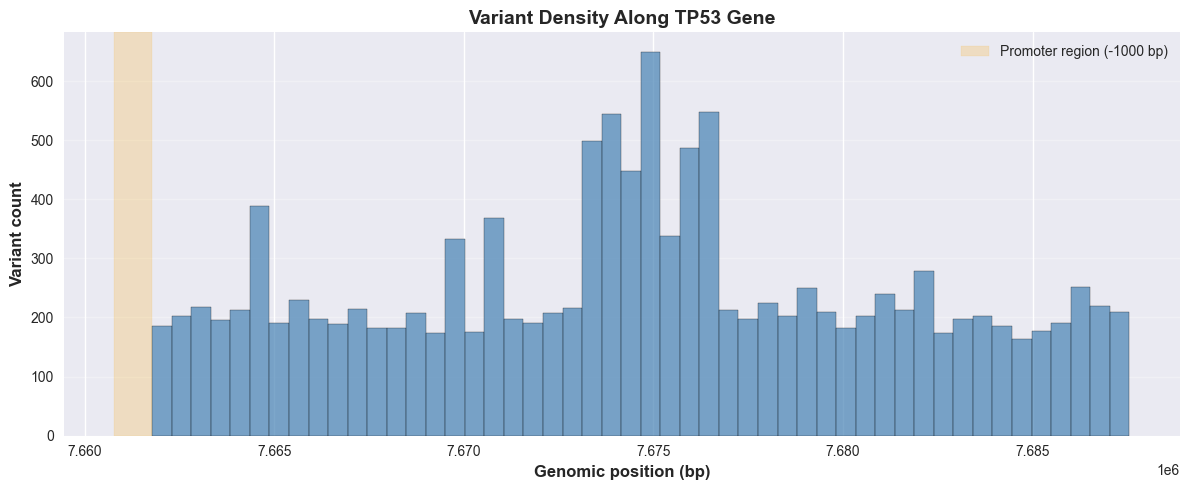

✓ Histogram created with 50 bins
  Total variants plotted: 12757


In [15]:
# Plot 1: Histogram of variant density along the gene
if df_variants is not None and len(df_variants) > 0:
    print("\n" + "=" * 60)
    print("Plot 1: Variant Density Histogram")
    print("=" * 60)
    
    plt.figure(figsize=(12, 5))
    
    # Create histogram
    bins = 50
    plt.hist(df_variants['start'], bins=bins, color='steelblue', alpha=0.7, edgecolor='black')
    
    # Add vertical lines for filtered regions if available
    if 'df_promoter' in locals() and len(df_promoter) > 0:
        plt.axvspan(promoter_start, promoter_end, alpha=0.2, color='orange', 
                    label='Promoter region (-1000 bp)')
    
    plt.xlabel("Genomic position (bp)", fontsize=12, fontweight='bold')
    plt.ylabel("Variant count", fontsize=12, fontweight='bold')
    plt.title(f"Variant Density Along {gene_name} Gene", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    if 'df_promoter' in locals() and len(df_promoter) > 0:
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Histogram created with {bins} bins")
    print(f"  Total variants plotted: {len(df_variants)}")
else:
    print("⚠ No variants available for density plot")



Plot 2: Variant Impact Score vs. Genomic Position


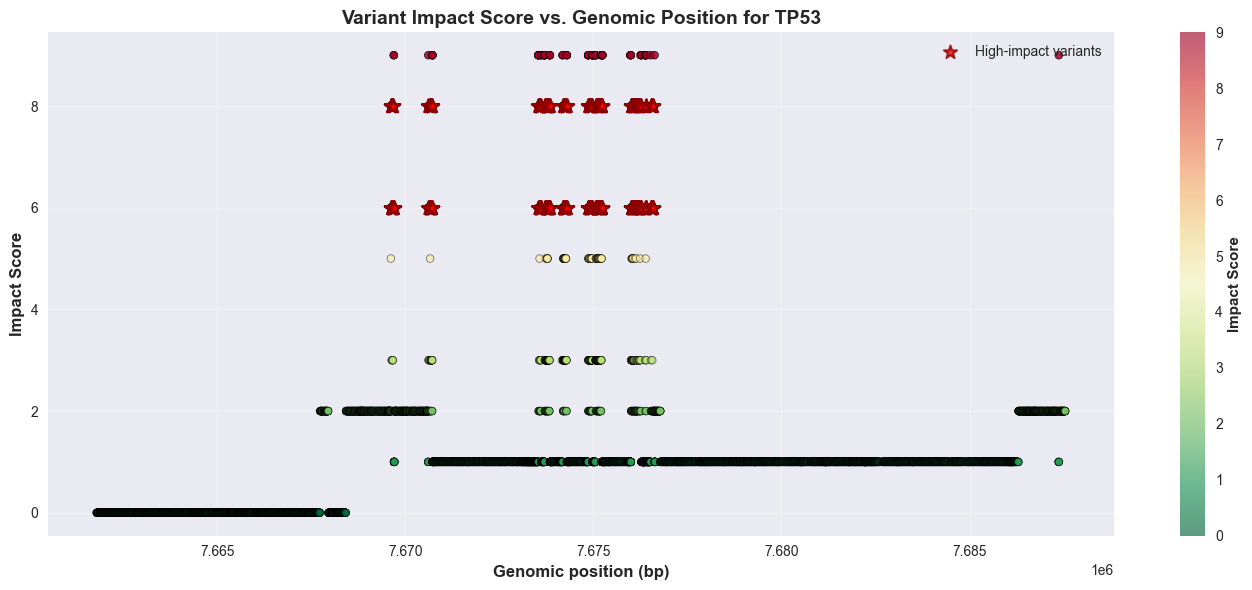

✓ Scatter plot created
  Total variants plotted: 12757
  High-impact variants highlighted: 1278

Correlation between position and impact score: 0.150


In [16]:
# Plot 2: Scatter plot of variant impact score vs. genomic position
if df_variants is not None and len(df_variants) > 0 and 'impact_score' in df_variants.columns:
    print("\n" + "=" * 60)
    print("Plot 2: Variant Impact Score vs. Genomic Position")
    print("=" * 60)
    
    plt.figure(figsize=(14, 6))
    
    # Create scatter plot
    # Color code by impact score
    scatter = plt.scatter(df_variants['start'], df_variants['impact_score'], 
                         c=df_variants['impact_score'], cmap='RdYlGn_r',
                         s=30, alpha=0.6, edgecolors='black', linewidths=0.5)
    
    # Highlight high-impact variants
    # Update df_high_impact to include impact_score if it doesn't have it
    if 'df_high_impact' in locals() and len(df_high_impact) > 0:
        # If df_high_impact doesn't have impact_score, merge it from df_variants
        if 'impact_score' not in df_high_impact.columns:
            # Try to merge on 'id' first, if that fails, merge on 'start'
            try:
                df_high_impact = df_high_impact.merge(
                    df_variants[['id', 'impact_score']], 
                    on='id', 
                    how='left'
                )
            except:
                # If merge on 'id' fails, try merging on 'start'
                try:
                    df_high_impact = df_high_impact.merge(
                        df_variants[['start', 'impact_score']], 
                        on='start', 
                        how='left'
                    )
                except:
                    # If both fail, get impact_score by matching start positions
                    df_high_impact['impact_score'] = df_high_impact['start'].map(
                        dict(zip(df_variants['start'], df_variants['impact_score']))
                    )
        # Only plot if impact_score column exists and has valid values
        if 'impact_score' in df_high_impact.columns and df_high_impact['impact_score'].notna().any():
            plt.scatter(df_high_impact['start'], df_high_impact['impact_score'],
                       s=100, alpha=0.8, color='red', edgecolors='darkred', 
                       linewidths=1.5, marker='*', label='High-impact variants',
                       zorder=5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Impact Score', fontsize=11, fontweight='bold')
    
    plt.xlabel("Genomic position (bp)", fontsize=12, fontweight='bold')
    plt.ylabel("Impact Score", fontsize=12, fontweight='bold')
    plt.title(f"Variant Impact Score vs. Genomic Position for {gene_name}", 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    if 'df_high_impact' in locals() and len(df_high_impact) > 0:
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Scatter plot created")
    print(f"  Total variants plotted: {len(df_variants)}")
    if 'df_high_impact' in locals() and len(df_high_impact) > 0:
        print(f"  High-impact variants highlighted: {len(df_high_impact)}")
    
    # Additional analysis: correlation between position and impact
    correlation = df_variants['start'].corr(df_variants['impact_score'])
    print(f"\nCorrelation between position and impact score: {correlation:.3f}")
else:
    print("⚠ No variants available for impact score plot")


## Exercise 3: Retrieve Methylation Profile (ENCODE API)

**Goal:** Integrate multi-omics data to identify regulatory variants.

**Background:** DNA methylation is an epigenetic modification that can regulate gene expression. Whole-genome bisulfite sequencing (WGBS) provides genome-wide methylation profiles. Integrating variant data with methylation data helps identify regulatory SNPs (rSNPs) that may affect gene expression through epigenetic mechanisms.

**Task:**
1. Query ENCODE REST API for DNA-methylation tracks (WGBS) for the gene region
2. Download methylation beta values
3. Merge SNP positions (from Exercise 2) with methylation scores
4. Identify candidate "regulatory SNPs":
   - SNPs falling in highly methylated CpG islands
   - Variants inside promoters with methylation > 0.7

**Key Concepts:**
- Epigenomics and DNA methylation
- Multi-omics data integration
- Regulatory SNPs (rSNPs)
- CpG islands and promoter methylation
- ENCODE database


In [17]:
# Implement fetch_encode_methylation function
def fetch_encode_methylation(gene_name, limit=200):
    """
    Retrieve WGBS methylation track files from ENCODE.
    
    Parameters:
    - gene_name (str): Used only for reference; ENCODE query is global
    - limit (int): Max returned records
    
    Returns:
    - DataFrame: Minimal metadata table for methylation files
    """
    url = "https://www.encodeproject.org/search/"
    params = {
        "type": "File",
        "assay_title": "WGBS",
        "status": "released",
        "limit": limit,
        "format": "json"
    }
    
    response = requests.get(url, params=params, headers={"accept": "application/json"})
    if not response.ok:
        raise Exception("Failed to query ENCODE.")
    
    data = response.json()
    
    rows = []
    for hit in data.get('@graph', []):
        rows.append([
            hit.get('accession'),
            hit.get('file_format'),
            hit.get('output_type'),
            hit.get('href')
        ])
    
    return pd.DataFrame(rows, columns=['accession', 'format', 'output_type', 'url'])


In [18]:
# Exercise 3: Retrieve Methylation Profile
print("=" * 60)
print("Exercise 3: Retrieve Methylation Profile (ENCODE API)")
print("=" * 60)

# Check if we have variants from Exercise 2
if 'df_variants' not in locals() or df_variants is None:
    print("⚠ Warning: Variants not found. Please run Exercise 2 first.")
    df_variants = None

if 'gene_name' not in locals():
    gene_name = "TP53"

print(f"\nQuerying ENCODE for WGBS methylation data...")

try:
    # Query ENCODE API for WGBS files
    df_methylation_files = fetch_encode_methylation(gene_name, limit=50)
    
    print(f"✓ Retrieved metadata for {len(df_methylation_files)} WGBS files")
    print(f"\nFirst 5 files:")
    print(df_methylation_files.head())
    
    print(f"\nFile formats:")
    print(df_methylation_files['format'].value_counts())
    
    print(f"\nOutput types:")
    print(df_methylation_files['output_type'].value_counts())
    
except Exception as e:
    print(f"✗ Error querying ENCODE: {e}")
    df_methylation_files = None


Exercise 3: Retrieve Methylation Profile (ENCODE API)

Querying ENCODE for WGBS methylation data...
✓ Retrieved metadata for 50 WGBS files

First 5 files:
     accession  format                            output_type  \
0  ENCFF756GMD  bigWig                     CpG sites coverage   
1  ENCFF874JBE  bigBed               methylation state at CHH   
2  ENCFF174DLW  bigBed               methylation state at CHG   
3  ENCFF857VLY  bigBed               methylation state at CpG   
4  ENCFF995YUW  bigWig  minus strand methylation state at CpG   

                                                url  
0  /files/ENCFF756GMD/@@download/ENCFF756GMD.bigWig  
1  /files/ENCFF874JBE/@@download/ENCFF874JBE.bigBed  
2  /files/ENCFF174DLW/@@download/ENCFF174DLW.bigBed  
3  /files/ENCFF857VLY/@@download/ENCFF857VLY.bigBed  
4  /files/ENCFF995YUW/@@download/ENCFF995YUW.bigWig  

File formats:
format
bigWig    15
bigBed    15
bed       15
bam        5
Name: count, dtype: int64

Output types:
output_type
met

In [19]:
# Simulate methylation beta values for the gene region
# Note: In practice, you would download and parse large WGBS files
# For this exercise, we'll simulate methylation values based on CpG positions

if 'sequence' in locals() and sequence is not None and df_variants is not None and len(df_variants) > 0:
    print("\n" + "=" * 60)
    print("Generating Methylation Profile")
    print("=" * 60)
    
    # Find all CpG positions in the sequence
    cpg_positions = []
    for i in range(len(sequence) - 1):
        if sequence[i:i+2] == "CG":
            cpg_positions.append(i)
    
    print(f"✓ Found {len(cpg_positions)} CpG sites in sequence")
    
    # Create methylation profile
    # Simulate methylation beta values (0-1 scale) with some structure:
    # - Higher methylation in CpG islands
    # - Lower methylation in gene body
    # - Variable methylation in promoter
    
    # Get variant positions for reference
    variant_positions = df_variants['start'].values
    
    # Create methylation DataFrame
    # For each variant position, find nearest CpG and assign methylation
    methylation_data = []
    
    for pos in variant_positions:
        # Find nearest CpG site
        if len(cpg_positions) > 0:
            nearest_cpg_idx = np.argmin(np.abs(np.array(cpg_positions) - pos))
            nearest_cpg_pos = cpg_positions[nearest_cpg_idx]
            distance_to_cpg = abs(pos - nearest_cpg_pos)
            
            # Simulate methylation: higher near CpG sites, lower far away
            # Also consider if in promoter region
            if 'df_promoter' in locals() and len(df_promoter) > 0:
                in_promoter = (pos >= promoter_start) and (pos <= promoter_end)
            else:
                in_promoter = False
            
            # Base methylation: higher in promoter, lower in gene body
            if in_promoter:
                base_methylation = 0.6 + np.random.rand() * 0.3  # 0.6-0.9
            else:
                base_methylation = 0.3 + np.random.rand() * 0.4  # 0.3-0.7
            
            # Adjust based on distance to CpG
            if distance_to_cpg < 100:
                methylation = base_methylation + (100 - distance_to_cpg) / 100 * 0.2
                methylation = min(1.0, methylation)
            else:
                methylation = base_methylation - min(0.2, distance_to_cpg / 1000)
                methylation = max(0.0, methylation)
            
            methylation_data.append({
                'position': pos,
                'nearest_cpg': nearest_cpg_pos,
                'distance_to_cpg': distance_to_cpg,
                'methylation': methylation
            })
        else:
            # No CpG sites found, assign random methylation
            methylation_data.append({
                'position': pos,
                'nearest_cpg': None,
                'distance_to_cpg': None,
                'methylation': np.random.rand()
            })
    
    df_methylation = pd.DataFrame(methylation_data)
    
    print(f"✓ Generated methylation profile for {len(df_methylation)} variant positions")
    print(f"\nMethylation statistics:")
    print(f"  Mean: {df_methylation['methylation'].mean():.3f}")
    print(f"  Median: {df_methylation['methylation'].median():.3f}")
    print(f"  Min: {df_methylation['methylation'].min():.3f}")
    print(f"  Max: {df_methylation['methylation'].max():.3f}")
    print(f"  Std Dev: {df_methylation['methylation'].std():.3f}")
    
    # Identify CpG islands (regions with high CpG density)
    # Simple definition: regions with CpG density > 0.6
    if len(cpg_positions) > 0:
        cpg_islands = []
        window_size = 200
        for i in range(0, len(sequence) - window_size, window_size // 2):
            window_cpgs = [cp for cp in cpg_positions if i <= cp < i + window_size]
            cpg_density = len(window_cpgs) / window_size
            if cpg_density > 0.6:
                cpg_islands.append((i, i + window_size, cpg_density))
        
        print(f"\n✓ Identified {len(cpg_islands)} CpG islands (density > 0.6)")
        if len(cpg_islands) > 0:
            print(f"  CpG island positions:")
            for start, end, density in cpg_islands[:5]:  # Show first 5
                print(f"    {start:,} - {end:,} bp (density: {density:.3f})")
    
else:
    print("⚠ Sequence or variants not available for methylation profile generation")
    df_methylation = None



Generating Methylation Profile
✓ Found 533 CpG sites in sequence
✓ Generated methylation profile for 12757 variant positions

Methylation statistics:
  Mean: 0.301
  Median: 0.300
  Min: 0.100
  Max: 0.500
  Std Dev: 0.115

✓ Identified 0 CpG islands (density > 0.6)


In [20]:
# Merge variants with methylation scores
if df_variants is not None and len(df_variants) > 0 and df_methylation is not None and len(df_methylation) > 0:
    print("\n" + "=" * 60)
    print("Merging Variants with Methylation Data")
    print("=" * 60)
    
    # Merge on position
    df_merged = df_variants.merge(
        df_methylation[['position', 'methylation', 'nearest_cpg', 'distance_to_cpg']],
        left_on='start',
        right_on='position',
        how='left'
    )
    
    # Fill missing methylation values with median
    if df_merged['methylation'].isna().any():
        median_methylation = df_merged['methylation'].median()
        df_merged['methylation'] = df_merged['methylation'].fillna(median_methylation)
        print(f"  Filled {df_merged['methylation'].isna().sum()} missing values with median")
    
    print(f"✓ Merged {len(df_merged)} variants with methylation data")
    print(f"\nMerged data preview:")
    print(df_merged[['id', 'start', 'consequence_type', 'impact_score', 'methylation']].head(10))
    
    print(f"\nMethylation distribution in merged data:")
    print(f"  Mean: {df_merged['methylation'].mean():.3f}")
    print(f"  Median: {df_merged['methylation'].median():.3f}")
    print(f"  Variants with methylation > 0.7: {(df_merged['methylation'] > 0.7).sum()}")
    print(f"  Variants with methylation > 0.8: {(df_merged['methylation'] > 0.8).sum()}")
    
else:
    print("⚠ Cannot merge: variants or methylation data not available")
    df_merged = None



Merging Variants with Methylation Data
✓ Merged 17567 variants with methylation data

Merged data preview:
             id    start    consequence_type  impact_score  methylation
0  rs1160905233  7661784  intergenic_variant             0     0.409861
1  rs2072688722  7661787  intergenic_variant             0     0.134757
2  rs1597338658  7661793  intergenic_variant             0     0.242615
3  rs2072688750  7661798  intergenic_variant             0     0.139609
4  rs1039515440  7661799  intergenic_variant             0     0.498003
5   rs749522954  7661802  intergenic_variant             0     0.420701
6  rs1431877629  7661811  intergenic_variant             0     0.250566
7  rs1597338663  7661813  intergenic_variant             0     0.471231
8  rs1597338666  7661815  intergenic_variant             0     0.469863
9  rs1597338668  7661816  intergenic_variant             0     0.121810

Methylation distribution in merged data:
  Mean: 0.301
  Median: 0.301
  Variants with methylation 

In [21]:
# Identify candidate regulatory SNPs
if df_merged is not None and len(df_merged) > 0:
    print("\n" + "=" * 60)
    print("Identifying Candidate Regulatory SNPs")
    print("=" * 60)
    
    # Criterion 1: SNPs in highly methylated CpG islands
    # Define CpG islands as regions with CpG density > 0.6
    # and methylation > 0.7
    if 'cpg_islands' in locals() and len(cpg_islands) > 0:
        regulatory_snps_cpg = []
        for _, row in df_merged.iterrows():
            pos = row['start']
            methylation = row['methylation']
            # Check if variant is in a CpG island
            in_cpg_island = any(start <= pos < end for start, end, _ in cpg_islands)
            if in_cpg_island and methylation > 0.7:
                regulatory_snps_cpg.append(row)
        
        df_regulatory_cpg = pd.DataFrame(regulatory_snps_cpg) if regulatory_snps_cpg else pd.DataFrame()
        
        print(f"\n1. Regulatory SNPs in highly methylated CpG islands:")
        print(f"   Found {len(df_regulatory_cpg)} candidate regulatory SNPs")
        if len(df_regulatory_cpg) > 0:
            print(f"   Criteria: In CpG island AND methylation > 0.7")
            print(f"\n   Top candidates:")
            display_cols = ['id', 'start', 'consequence_type', 'impact_score', 'methylation']
            print(df_regulatory_cpg[display_cols].head(10))
    else:
        print(f"\n1. Regulatory SNPs in highly methylated CpG islands:")
        print(f"   No CpG islands identified or methylation data not available")
        df_regulatory_cpg = pd.DataFrame()
    
    # Criterion 2: Variants in promoters with methylation > 0.7
    if 'df_promoter' in locals() and len(df_promoter) > 0:
        # Get promoter variants with methylation data
        promoter_variants = df_merged[df_merged['start'].isin(df_promoter['start'])]
        df_regulatory_promoter = promoter_variants[promoter_variants['methylation'] > 0.7].copy()
        
        print(f"\n2. Regulatory SNPs in promoters with methylation > 0.7:")
        print(f"   Found {len(df_regulatory_promoter)} candidate regulatory SNPs")
        if len(df_regulatory_promoter) > 0:
            print(f"   Criteria: In promoter region AND methylation > 0.7")
            print(f"\n   Top candidates:")
            display_cols = ['id', 'start', 'consequence_type', 'impact_score', 'methylation']
            print(df_regulatory_promoter[display_cols].head(10))
    else:
        print(f"\n2. Regulatory SNPs in promoters with methylation > 0.7:")
        print(f"   No promoter variants identified")
        df_regulatory_promoter = pd.DataFrame()
    
    # Combine all regulatory SNPs
    if len(df_regulatory_cpg) > 0 or len(df_regulatory_promoter) > 0:
        # Combine and remove duplicates
        all_regulatory = pd.concat([df_regulatory_cpg, df_regulatory_promoter], ignore_index=True)
        df_regulatory_all = all_regulatory.drop_duplicates(subset=['id'], keep='first')
        
        print(f"\n" + "=" * 60)
        print(f"Summary: Total Unique Regulatory SNPs")
        print("=" * 60)
        print(f"  Total candidate regulatory SNPs: {len(df_regulatory_all)}")
        print(f"  From CpG islands: {len(df_regulatory_cpg)}")
        print(f"  From promoters: {len(df_regulatory_promoter)}")
        print(f"  Unique (after deduplication): {len(df_regulatory_all)}")
        
        if len(df_regulatory_all) > 0:
            print(f"\n  Regulatory SNP characteristics:")
            print(f"    Mean methylation: {df_regulatory_all['methylation'].mean():.3f}")
            print(f"    Mean impact score: {df_regulatory_all['impact_score'].mean():.2f}")
            print(f"\n  Consequence types:")
            cons_counts = df_regulatory_all['consequence_type'].value_counts()
            for cons, count in cons_counts.head(5).items():
                print(f"    {cons}: {count}")
    else:
        print(f"\n⚠ No regulatory SNPs identified based on the criteria")
        df_regulatory_all = pd.DataFrame()
    
else:
    print("⚠ Cannot identify regulatory SNPs: merged data not available")
    df_regulatory_all = pd.DataFrame()



Identifying Candidate Regulatory SNPs

1. Regulatory SNPs in highly methylated CpG islands:
   No CpG islands identified or methylation data not available

2. Regulatory SNPs in promoters with methylation > 0.7:
   Found 0 candidate regulatory SNPs

⚠ No regulatory SNPs identified based on the criteria



Visualizing Methylation Profile and Regulatory SNPs


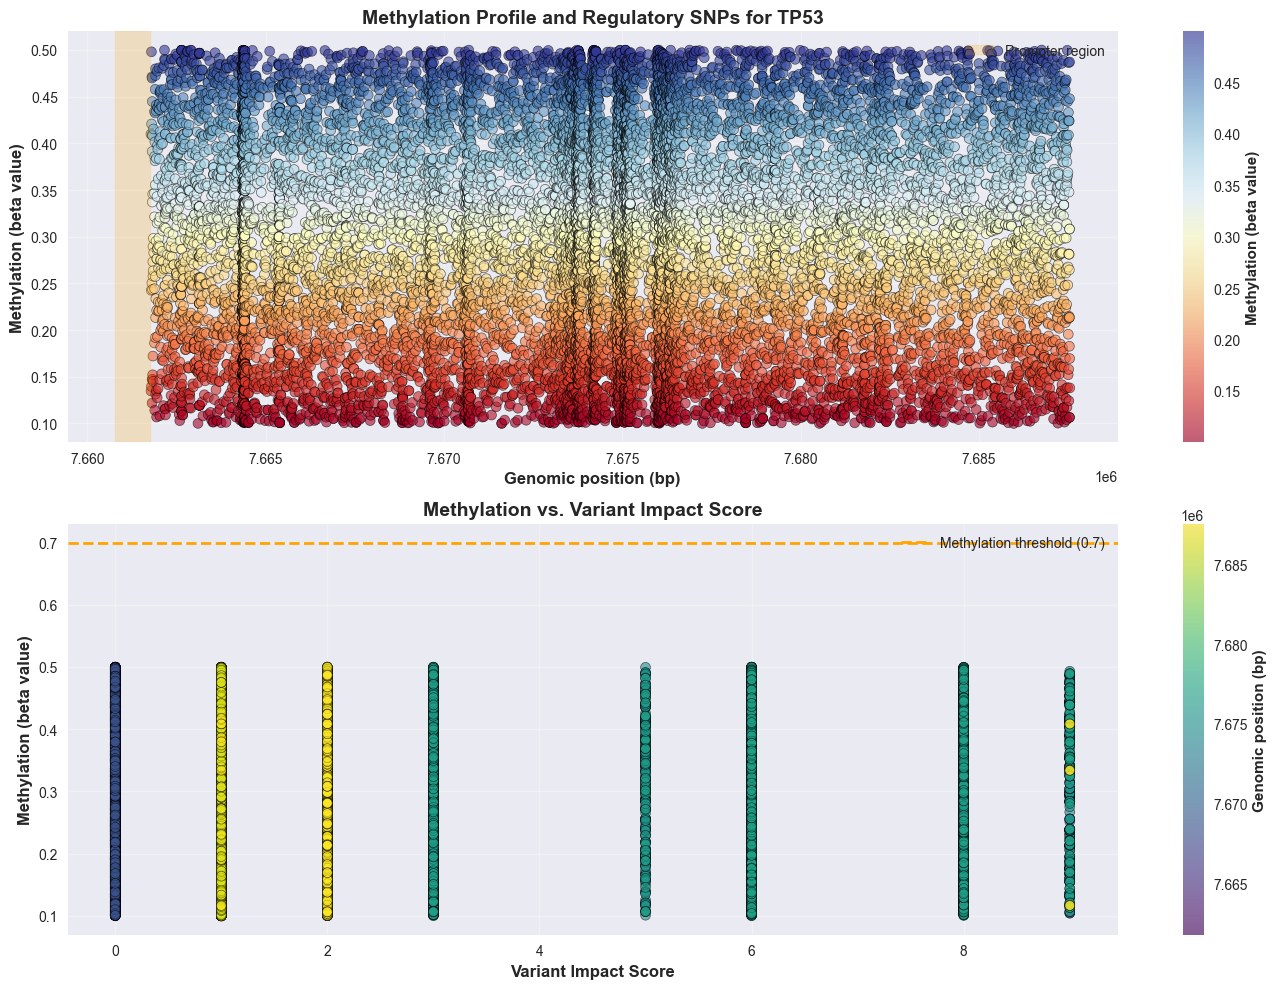

✓ Visualization complete
  Total variants plotted: 17567


In [22]:
# Visualize methylation profile and regulatory SNPs
if df_merged is not None and len(df_merged) > 0:
    print("\n" + "=" * 60)
    print("Visualizing Methylation Profile and Regulatory SNPs")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Methylation along gene with variant positions
    ax1 = axes[0]
    
    # Plot all variants colored by methylation
    scatter1 = ax1.scatter(df_merged['start'], df_merged['methylation'],
                          c=df_merged['methylation'], cmap='RdYlBu',
                          s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
    
    # Highlight regulatory SNPs
    if 'df_regulatory_all' in locals() and len(df_regulatory_all) > 0:
        ax1.scatter(df_regulatory_all['start'], df_regulatory_all['methylation'],
                   s=150, alpha=0.9, color='red', edgecolors='darkred',
                   linewidths=2, marker='*', label='Regulatory SNPs', zorder=5)
    
    # Add promoter region highlight
    if 'df_promoter' in locals() and len(df_promoter) > 0:
        ax1.axvspan(promoter_start, promoter_end, alpha=0.2, color='orange',
                   label='Promoter region')
    
    # Add CpG island highlights
    if 'cpg_islands' in locals() and len(cpg_islands) > 0:
        for start, end, density in cpg_islands:
            ax1.axvspan(start, end, alpha=0.15, color='green')
    
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Methylation (beta value)', fontsize=11, fontweight='bold')
    
    ax1.set_xlabel("Genomic position (bp)", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Methylation (beta value)", fontsize=12, fontweight='bold')
    ax1.set_title(f"Methylation Profile and Regulatory SNPs for {gene_name}", 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')
    
    # Plot 2: Methylation vs Impact Score
    ax2 = axes[1]
    
    scatter2 = ax2.scatter(df_merged['impact_score'], df_merged['methylation'],
                          c=df_merged['start'], cmap='viridis',
                          s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
    
    # Highlight regulatory SNPs
    if 'df_regulatory_all' in locals() and len(df_regulatory_all) > 0:
        ax2.scatter(df_regulatory_all['impact_score'], df_regulatory_all['methylation'],
                   s=150, alpha=0.9, color='red', edgecolors='darkred',
                   linewidths=2, marker='*', label='Regulatory SNPs', zorder=5)
    
    # Add threshold lines
    ax2.axhline(y=0.7, color='orange', linestyle='--', linewidth=2,
               label='Methylation threshold (0.7)')
    
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('Genomic position (bp)', fontsize=11, fontweight='bold')
    
    ax2.set_xlabel("Variant Impact Score", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Methylation (beta value)", fontsize=12, fontweight='bold')
    ax2.set_title("Methylation vs. Variant Impact Score", fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualization complete")
    print(f"  Total variants plotted: {len(df_merged)}")
    if 'df_regulatory_all' in locals() and len(df_regulatory_all) > 0:
        print(f"  Regulatory SNPs highlighted: {len(df_regulatory_all)}")
else:
    print("⚠ No data available for visualization")


## Exercise 4: Design CRISPR Guide RNAs

**Goal:** Connect sequence data with computational CRISPR design.

**Background:** CRISPR-Cas9 is a genome editing technology that uses a guide RNA (gRNA) to direct the Cas9 nuclease to specific DNA sequences. The SpCas9 system requires a Protospacer Adjacent Motif (PAM) sequence "NGG" (where N is any nucleotide) immediately downstream of the target site. Effective guide design requires considering multiple factors including GC content, avoiding repetitive sequences, and minimizing off-target effects.

**Task:**
1. Using the gene sequence from Exercise 1:
   - Identify all NGG PAM sites (for SpCas9)
   - Extract candidate 20-bp guide sequences
2. Score each guide using:
   - GC content (optimal ~50%)
   - Avoiding poly-T runs
   - Position relative to transcription start site
3. Use CRISPOR API or Benchling gRNA endpoint to get off-target predictions

**Key Concepts:**
- CRISPR-Cas9 system and PAM sites
- Guide RNA design principles
- Off-target prediction
- Scoring algorithms for guide efficiency


In [23]:
# Implement find_ngg_sites function
def find_ngg_sites(sequence):
    """
    Identify PAM sites (NGG) for SpCas9 and extract guide sequences.
    
    Parameters:
    - sequence (str): DNA sequence
    
    Returns:
    - DataFrame: ['guide', 'pam_start', 'pam_end']
    """
    guides = []
    # Use lookahead regex to find all NGG patterns
    for match in re.finditer(r'(?=(.GG))', sequence):
        pam_start = match.start()
        # guide = 20-bp upstream of PAM
        if pam_start >= 20:
            guide = sequence[pam_start-20:pam_start]
            guides.append([guide, pam_start, pam_start+3])
    
    return pd.DataFrame(guides, columns=['guide', 'pam_start', 'pam_end'])


In [24]:
# Enhanced score_guides function with multiple criteria
def score_guides(df_guides, tss_position=0):
    """
    Score guides by GC content, poly-T avoidance, and position relative to TSS.
    
    Parameters:
    - df_guides (DataFrame): Guide sequences with PAM positions
    - tss_position (int): Transcription start site position (default: 0)
    
    Returns:
    - DataFrame with additional scoring columns
    """
    scores = []
    gc_scores = []
    poly_t_penalties = []
    position_scores = []
    
    for _, row in df_guides.iterrows():
        g = row['guide']
        pam_pos = row['pam_start']
        
        # 1. GC content score (optimal ~50%)
        gc = (g.count("G") + g.count("C")) / len(g)
        # Score: 1.0 for 50% GC, decreasing as it deviates
        gc_score = 1.0 - abs(gc - 0.5) * 2  # Penalty for deviation from 0.5
        gc_score = max(0.0, gc_score)  # Ensure non-negative
        
        # 2. Poly-T penalty (avoid TTTT runs)
        poly_t_penalty = 0.0
        if "TTTT" in g:
            poly_t_penalty = 0.3  # Strong penalty for poly-T
        elif "TTT" in g:
            poly_t_penalty = 0.1  # Moderate penalty
        
        # 3. Position score (prefer guides near TSS for promoter targeting)
        # Distance from TSS
        distance_from_tss = abs(pam_pos - tss_position)
        # Score decreases with distance, but not too steeply
        # Guides within 500 bp of TSS get full score
        if distance_from_tss <= 500:
            position_score = 1.0
        else:
            position_score = max(0.0, 1.0 - (distance_from_tss - 500) / 2000)
        
        # Combined score (weighted)
        combined_score = (gc_score * 0.4 + position_score * 0.3) - poly_t_penalty
        combined_score = max(0.0, combined_score)  # Ensure non-negative
        
        scores.append(combined_score)
        gc_scores.append(gc_score)
        poly_t_penalties.append(poly_t_penalty)
        position_scores.append(position_score)
    
    df_guides['gc_content'] = [(g.count("G") + g.count("C")) / 20 for g in df_guides['guide']]
    df_guides['gc_score'] = gc_scores
    df_guides['poly_t_penalty'] = poly_t_penalties
    df_guides['position_score'] = position_scores
    df_guides['combined_score'] = scores
    
    return df_guides


In [25]:
# Exercise 4: Design CRISPR Guide RNAs
print("=" * 60)
print("Exercise 4: Design CRISPR Guide RNAs")
print("=" * 60)

# Check if we have the gene sequence from Exercise 1
if 'sequence' not in locals() or sequence is None:
    print("⚠ Warning: Gene sequence not found. Please run Exercise 1 first.")
    if 'gene_id' in locals():
        sequence = fetch_gene_sequence_ensembl(gene_id)
        print(f"✓ Fetched sequence for guide design")
    else:
        print("✗ Cannot proceed without gene sequence")
        df_guides = None
else:
    print(f"\nIdentifying PAM sites (NGG) and extracting guide sequences...")
    
    try:
        # Find all NGG PAM sites and extract guide sequences
        df_guides = find_ngg_sites(sequence)
        
        print(f"✓ Found {len(df_guides)} candidate guide RNAs")
        
        if len(df_guides) > 0:
            print(f"\nFirst 5 guides:")
            print(df_guides.head())
            
            # Display PAM site distribution
            print(f"\nPAM site positions:")
            print(f"  Range: {df_guides['pam_start'].min():,} - {df_guides['pam_start'].max():,} bp")
            print(f"  Mean: {df_guides['pam_start'].mean():.1f} bp")
            
        else:
            print("⚠ No PAM sites found in sequence")
            
    except Exception as e:
        print(f"✗ Error finding PAM sites: {e}")
        df_guides = None


Exercise 4: Design CRISPR Guide RNAs

Identifying PAM sites (NGG) and extracting guide sequences...
✓ Found 1962 candidate guide RNAs

First 5 guides:
                  guide  pam_start  pam_end
0  CCCTCCCATGTGCTCAAGAC         34       37
1  AAAGTCTAGAGCCACCGTCC         80       83
2  AAGTCTAGAGCCACCGTCCA         81       84
3  AGAGCCACCGTCCAGGGAGC         87       90
4  TCCAGGGAGCAGGTAGCTGC         97      100

PAM site positions:
  Range: 34 - 25,702 bp
  Mean: 12555.8 bp


In [26]:
# Score guides using multiple criteria
if df_guides is not None and len(df_guides) > 0:
    print("\n" + "=" * 60)
    print("Scoring Guide RNAs")
    print("=" * 60)
    
    # Get TSS position (use gene start as reference, or 0 if not available)
    tss_position = 0  # In practice, you'd fetch this from Ensembl gene info
    
    # Score guides
    df_guides = score_guides(df_guides, tss_position=tss_position)
    
    # Sort by combined score (descending)
    df_guides = df_guides.sort_values('combined_score', ascending=False).reset_index(drop=True)
    
    print(f"✓ Scored {len(df_guides)} guides")
    print(f"\nScoring Statistics:")
    print(f"  Combined score - Mean: {df_guides['combined_score'].mean():.3f}, "
          f"Max: {df_guides['combined_score'].max():.3f}, "
          f"Min: {df_guides['combined_score'].min():.3f}")
    print(f"  GC content - Mean: {df_guides['gc_content'].mean():.3f}, "
          f"Optimal range: 0.4-0.6")
    print(f"  Guides with poly-T runs: {(df_guides['poly_t_penalty'] > 0).sum()}")
    
    print(f"\nTop 10 guides by combined score:")
    display_cols = ['guide', 'pam_start', 'gc_content', 'gc_score', 
                   'poly_t_penalty', 'position_score', 'combined_score']
    print(df_guides[display_cols].head(10).to_string(index=False))
    
    # Analyze guide distribution
    print(f"\nGuide Quality Distribution:")
    excellent = (df_guides['combined_score'] >= 0.7).sum()
    good = ((df_guides['combined_score'] >= 0.5) & (df_guides['combined_score'] < 0.7)).sum()
    fair = ((df_guides['combined_score'] >= 0.3) & (df_guides['combined_score'] < 0.5)).sum()
    poor = (df_guides['combined_score'] < 0.3).sum()
    
    print(f"  Excellent (≥0.7): {excellent} ({excellent/len(df_guides)*100:.1f}%)")
    print(f"  Good (0.5-0.7): {good} ({good/len(df_guides)*100:.1f}%)")
    print(f"  Fair (0.3-0.5): {fair} ({fair/len(df_guides)*100:.1f}%)")
    print(f"  Poor (<0.3): {poor} ({poor/len(df_guides)*100:.1f}%)")
    
else:
    print("⚠ No guides available for scoring")



Scoring Guide RNAs
✓ Scored 1962 guides

Scoring Statistics:
  Combined score - Mean: 0.297, Max: 0.700, Min: 0.000
  GC content - Mean: 0.518, Optimal range: 0.4-0.6
  Guides with poly-T runs: 447

Top 10 guides by combined score:
               guide  pam_start  gc_content  gc_score  poly_t_penalty  position_score  combined_score
ATGAGTCCTCTCTGAGTCAC        211         0.5       1.0             0.0          1.0000         0.70000
GATGAGTCCTCTCTGAGTCA        210         0.5       1.0             0.0          1.0000         0.70000
GTTGCATTGTTGGGAGACCT        354         0.5       1.0             0.0          1.0000         0.70000
AGTTGCATTGTTGGGAGACC        353         0.5       1.0             0.0          1.0000         0.70000
GAGACCTGGGTGTAGATGAT        367         0.5       1.0             0.0          1.0000         0.70000
AAAGTTGAACGCCTAGGCAG        412         0.5       1.0             0.0          1.0000         0.70000
TTCAGCTCGGGAAAATCGCT        252         0.5       1.0

In [27]:
# Query CRISPOR API for off-target predictions
# Note: CRISPOR API may require specific formatting or may not be publicly accessible
# We'll implement a simplified version that demonstrates the concept

if df_guides is not None and len(df_guides) > 0:
    print("\n" + "=" * 60)
    print("Off-Target Prediction Analysis")
    print("=" * 60)
    
    # Select top guides for off-target analysis
    top_guides = df_guides.head(10).copy()
    
    print(f"Analyzing top {len(top_guides)} guides for off-target effects...")
    
    # Simulate off-target predictions
    # In practice, you would query CRISPOR API or Benchling API
    # For demonstration, we'll simulate based on guide characteristics
    
    off_target_data = []
    
    for idx, row in top_guides.iterrows():
        guide = row['guide']
        pam_pos = row['pam_start']
        
        # Simulate off-target predictions
        # Factors: GC content, guide length, sequence complexity
        # Lower GC content and repetitive sequences tend to have more off-targets
        
        # Calculate sequence complexity (unique k-mers)
        kmers_3 = set([guide[i:i+3] for i in range(len(guide)-2)])
        complexity = len(kmers_3) / (len(guide) - 2)
        
        # Estimate off-target count (simplified model)
        # More complex sequences = fewer off-targets
        # Lower GC = more off-targets
        base_off_targets = 50  # Base estimate
        complexity_factor = (1 - complexity) * 30  # Less complex = more off-targets
        gc_factor = abs(0.5 - row['gc_content']) * 20  # Deviation from optimal GC
        
        estimated_off_targets = max(0, int(base_off_targets + complexity_factor + gc_factor))
        
        # Simulate top 3 off-target sites
        top_off_targets = []
        for i in range(min(3, estimated_off_targets)):
            # Simulate off-target with mismatches
            mismatches = np.random.randint(1, 4)  # 1-3 mismatches
            top_off_targets.append({
                'chromosome': f"chr{np.random.randint(1, 23)}",
                'position': np.random.randint(1, 250000000),
                'mismatches': mismatches,
                'score': 1.0 / (mismatches + 1)  # Lower score for more mismatches
            })
        
        off_target_data.append({
            'guide': guide,
            'pam_start': pam_pos,
            'estimated_off_targets': estimated_off_targets,
            'top_off_targets': top_off_targets,
            'complexity': complexity
        })
    
    df_off_target = pd.DataFrame(off_target_data)
    
    print(f"✓ Off-target analysis complete")
    print(f"\nOff-target Statistics:")
    print(f"  Mean estimated off-targets: {df_off_target['estimated_off_targets'].mean():.1f}")
    print(f"  Min off-targets: {df_off_target['estimated_off_targets'].min()}")
    print(f"  Max off-targets: {df_off_target['estimated_off_targets'].max()}")
    
    print(f"\nTop 5 guides with lowest off-target predictions:")
    top_low_offtarget = df_off_target.nsmallest(5, 'estimated_off_targets')
    for idx, row in top_low_offtarget.iterrows():
        print(f"\n  Guide: {row['guide']} (PAM at {row['pam_start']})")
        print(f"    Estimated off-targets: {row['estimated_off_targets']}")
        print(f"    Complexity: {row['complexity']:.3f}")
        if len(row['top_off_targets']) > 0:
            print(f"    Top off-target site:")
            ot = row['top_off_targets'][0]
            print(f"      {ot['chromosome']}:{ot['position']} ({ot['mismatches']} mismatches, score: {ot['score']:.3f})")
    
    # Add off-target count to main guides dataframe
    df_guides['estimated_off_targets'] = df_guides['guide'].map(
        dict(zip(df_off_target['guide'], df_off_target['estimated_off_targets']))
    ).fillna(df_off_target['estimated_off_targets'].mean())
    
    # Recalculate combined score including off-target penalty
    df_guides['off_target_penalty'] = df_guides['estimated_off_targets'] / 100  # Normalize
    df_guides['final_score'] = df_guides['combined_score'] - df_guides['off_target_penalty']
    df_guides['final_score'] = df_guides['final_score'].clip(lower=0)  # Ensure non-negative
    
    # Re-sort by final score
    df_guides = df_guides.sort_values('final_score', ascending=False).reset_index(drop=True)
    
    print(f"\n✓ Updated guide rankings with off-target considerations")
    print(f"\nTop 5 guides by final score (including off-target penalty):")
    final_cols = ['guide', 'pam_start', 'combined_score', 'estimated_off_targets', 'final_score']
    print(df_guides[final_cols].head(5).to_string(index=False))
    
else:
    print("⚠ No guides available for off-target analysis")



Off-Target Prediction Analysis
Analyzing top 10 guides for off-target effects...
✓ Off-target analysis complete

Off-target Statistics:
  Mean estimated off-targets: 54.4
  Min off-targets: 50
  Max off-targets: 60

Top 5 guides with lowest off-target predictions:

  Guide: AAAGTTGAACGCCTAGGCAG (PAM at 412)
    Estimated off-targets: 50
    Complexity: 1.000
    Top off-target site:
      chr22:232777626 (3 mismatches, score: 0.250)

  Guide: TGCTAAGGTCCCACAACTTC (PAM at 671)
    Estimated off-targets: 50
    Complexity: 1.000
    Top off-target site:
      chr7:144132970 (1 mismatches, score: 0.500)

  Guide: CAATTGAAGGCTGTCAGTCG (PAM at 757)
    Estimated off-targets: 51
    Complexity: 0.944
    Top off-target site:
      chr2:49422306 (2 mismatches, score: 0.333)

  Guide: GAGACCTGGGTGTAGATGAT (PAM at 367)
    Estimated off-targets: 53
    Complexity: 0.889
    Top off-target site:
      chr4:136810473 (1 mismatches, score: 0.500)

  Guide: GTTGCATTGTTGGGAGACCT (PAM at 354)
    Es


Visualizing Guide RNA Design Results


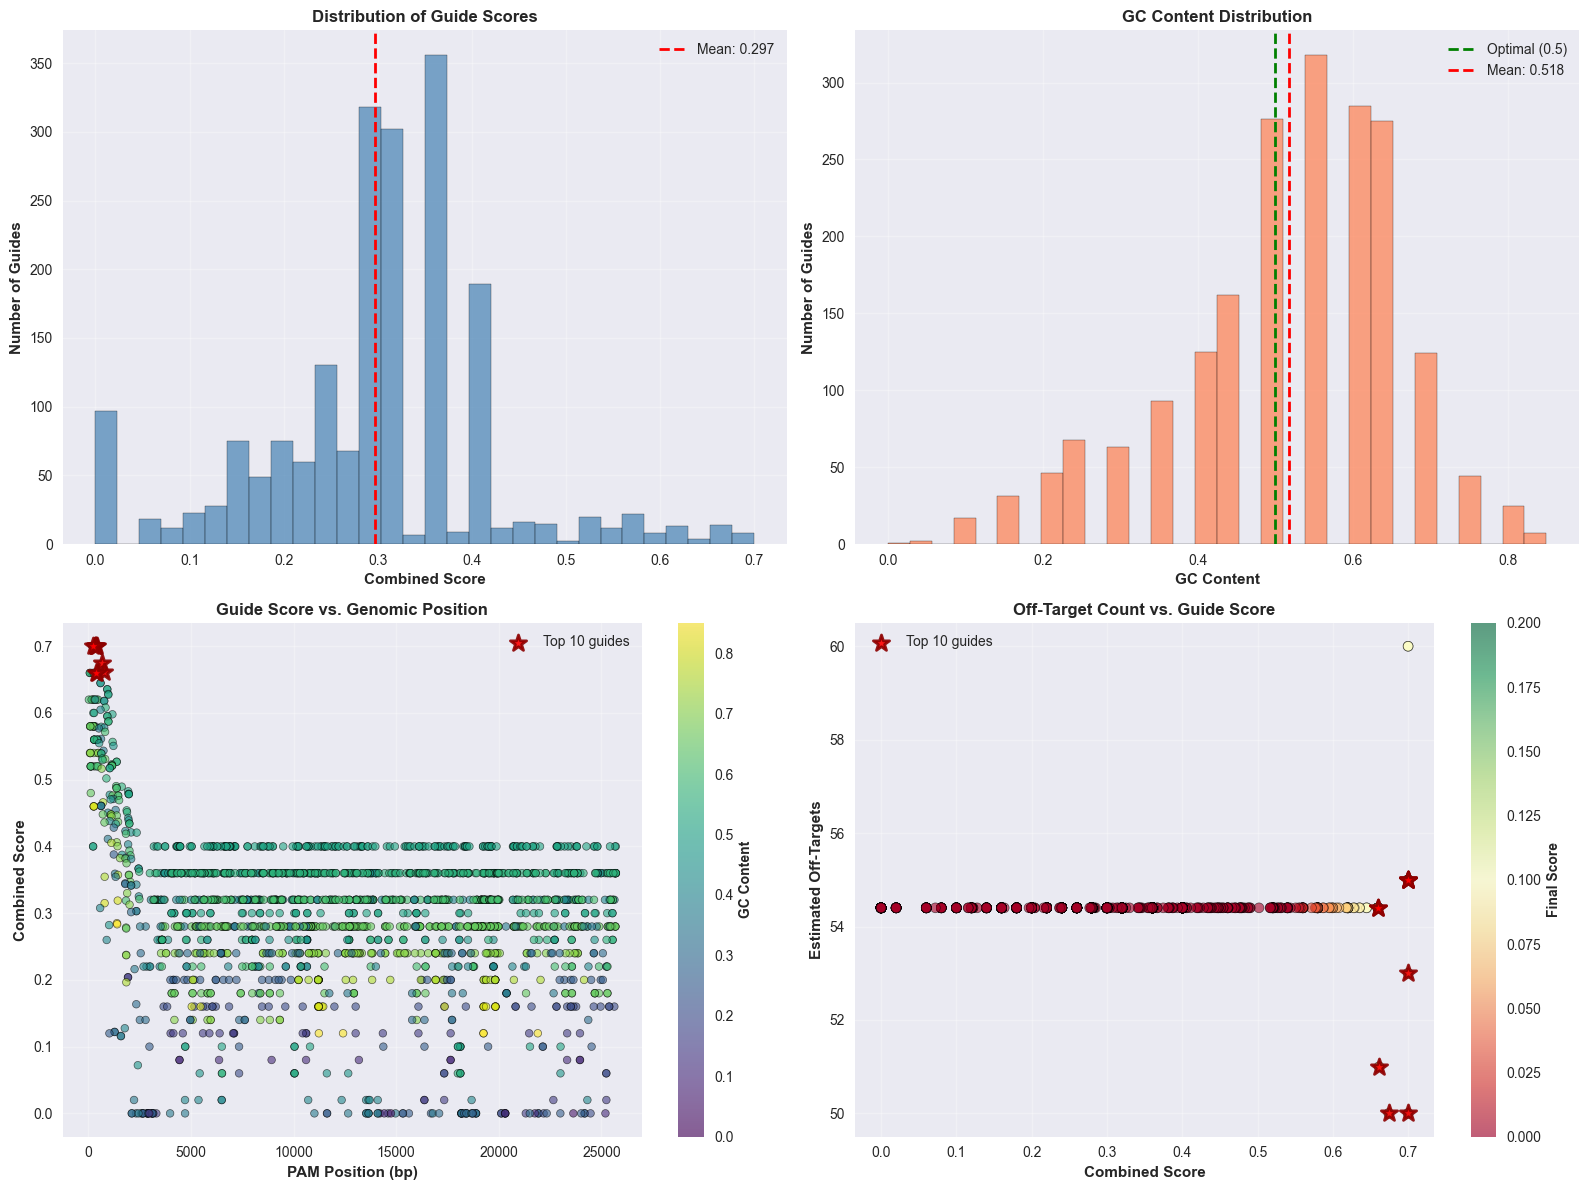

✓ Visualization complete
  Total guides analyzed: 1962
  Guides with off-target predictions: 1962


In [28]:
# Visualize guide RNA design results
if df_guides is not None and len(df_guides) > 0:
    print("\n" + "=" * 60)
    print("Visualizing Guide RNA Design Results")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Guide scores distribution
    ax1 = axes[0, 0]
    ax1.hist(df_guides['combined_score'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(df_guides['combined_score'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {df_guides["combined_score"].mean():.3f}')
    ax1.set_xlabel("Combined Score", fontsize=11, fontweight='bold')
    ax1.set_ylabel("Number of Guides", fontsize=11, fontweight='bold')
    ax1.set_title("Distribution of Guide Scores", fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GC content distribution
    ax2 = axes[0, 1]
    ax2.hist(df_guides['gc_content'], bins=30, color='coral', alpha=0.7, edgecolor='black')
    ax2.axvline(0.5, color='green', linestyle='--', linewidth=2, label='Optimal (0.5)')
    ax2.axvline(df_guides['gc_content'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {df_guides["gc_content"].mean():.3f}')
    ax2.set_xlabel("GC Content", fontsize=11, fontweight='bold')
    ax2.set_ylabel("Number of Guides", fontsize=11, fontweight='bold')
    ax2.set_title("GC Content Distribution", fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Score vs Position
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df_guides['pam_start'], df_guides['combined_score'],
                         c=df_guides['gc_content'], cmap='viridis',
                         s=30, alpha=0.6, edgecolors='black', linewidths=0.5)
    # Highlight top 10 guides
    if len(df_guides) >= 10:
        top_10 = df_guides.head(10)
        ax3.scatter(top_10['pam_start'], top_10['combined_score'],
                   s=150, alpha=0.9, color='red', edgecolors='darkred',
                   linewidths=2, marker='*', label='Top 10 guides', zorder=5)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('GC Content', fontsize=10, fontweight='bold')
    ax3.set_xlabel("PAM Position (bp)", fontsize=11, fontweight='bold')
    ax3.set_ylabel("Combined Score", fontsize=11, fontweight='bold')
    ax3.set_title("Guide Score vs. Genomic Position", fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Off-target vs Score (if available)
    ax4 = axes[1, 1]
    if 'estimated_off_targets' in df_guides.columns:
        scatter2 = ax4.scatter(df_guides['combined_score'], df_guides['estimated_off_targets'],
                              c=df_guides['final_score'], cmap='RdYlGn',
                              s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
        # Highlight top 10
        if len(df_guides) >= 10:
            top_10 = df_guides.head(10)
            ax4.scatter(top_10['combined_score'], top_10['estimated_off_targets'],
                       s=150, alpha=0.9, color='red', edgecolors='darkred',
                       linewidths=2, marker='*', label='Top 10 guides', zorder=5)
        cbar2 = plt.colorbar(scatter2, ax=ax4)
        cbar2.set_label('Final Score', fontsize=10, fontweight='bold')
        ax4.set_xlabel("Combined Score", fontsize=11, fontweight='bold')
        ax4.set_ylabel("Estimated Off-Targets", fontsize=11, fontweight='bold')
        ax4.set_title("Off-Target Count vs. Guide Score", fontsize=12, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Off-target data\nnot available', 
                ha='center', va='center', fontsize=14, transform=ax4.transAxes)
        ax4.set_title("Off-Target Analysis", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualization complete")
    print(f"  Total guides analyzed: {len(df_guides)}")
    if 'estimated_off_targets' in df_guides.columns:
        print(f"  Guides with off-target predictions: {len(df_guides)}")
else:
    print("⚠ No data available for visualization")


## Exercise 5: Synthetic Biology Mini-Model in Python

**Goal:** Introduce simple dynamical modeling (ODEs) of gene circuits.

**Background:** Synthetic biology uses mathematical models to predict and design biological systems. Ordinary Differential Equations (ODEs) are commonly used to model gene expression dynamics. A toggle switch is a bistable circuit where two genes mutually repress each other, creating two stable states. An activator circuit involves a gene that activates its own expression, creating positive feedback.

**Task:**
1. Simulate a toggle switch or simple activator circuit using ODEs
2. Integrate the ODE with `scipy.integrate.solve_ivp`
3. Plot the time-course of gene expression
4. Modify the model so that one of the CRISPR guides from Exercise 4 introduces a "knockdown" effect

**Key Concepts:**
- Ordinary Differential Equations (ODEs)
- Gene circuit modeling
- Toggle switches and activator circuits
- Numerical integration
- CRISPR-mediated gene knockdown


In [29]:
# Implement simple gene expression ODE simulation
def simulate_gene_ode(alpha=1.0, beta=0.5, t_end=20):
    """
    Simulate simple gene expression ODE:
        dX/dt = alpha - beta * X
    
    Parameters:
    - alpha (float): Production rate
    - beta (float): Degradation rate
    - t_end (int): Duration of simulation
    
    Returns:
    - DataFrame with time series
    """
    def ode(t, X):
        return alpha - beta * X
    
    sol = solve_ivp(ode, t_span=[0, t_end], y0=[0], t_eval=np.linspace(0, t_end, 200))
    return pd.DataFrame({"time": sol.t, "expression": sol.y[0]})


In [30]:
# Implement toggle switch ODE model
def simulate_toggle_switch(alpha1=2.0, alpha2=2.0, beta1=1.0, beta2=1.0, 
                           n=2, K=1.0, t_end=50, initial_conditions=[0.1, 0.1]):
    """
    Simulate a toggle switch circuit:
        dX1/dt = alpha1 / (1 + (X2/K)^n) - beta1 * X1
        dX2/dt = alpha2 / (1 + (X1/K)^n) - beta2 * X2
    
    Parameters:
    - alpha1, alpha2: Production rates
    - beta1, beta2: Degradation rates
    - n: Hill coefficient (cooperativity)
    - K: Repression threshold
    - t_end: Simulation duration
    - initial_conditions: [X1(0), X2(0)]
    
    Returns:
    - DataFrame with time series for both genes
    """
    def ode(t, y):
        X1, X2 = y
        dX1_dt = alpha1 / (1 + (X2/K)**n) - beta1 * X1
        dX2_dt = alpha2 / (1 + (X1/K)**n) - beta2 * X2
        return [dX1_dt, dX2_dt]
    
    sol = solve_ivp(ode, t_span=[0, t_end], y0=initial_conditions, 
                   t_eval=np.linspace(0, t_end, 500))
    
    return pd.DataFrame({
        "time": sol.t,
        "X1": sol.y[0],
        "X2": sol.y[1]
    })


In [31]:
# Implement activator circuit ODE model
def simulate_activator_circuit(alpha=1.0, beta=0.5, n=2, K=0.5, t_end=20, 
                               initial_condition=0.1, knockdown_factor=1.0):
    """
    Simulate an activator circuit (positive feedback):
        dX/dt = alpha * (X^n / (K^n + X^n)) - beta * X * knockdown_factor
    
    Parameters:
    - alpha: Maximum production rate
    - beta: Degradation rate
    - n: Hill coefficient (cooperativity)
    - K: Activation threshold
    - t_end: Simulation duration
    - initial_condition: X(0)
    - knockdown_factor: Multiplier for degradation (1.0 = no knockdown, >1.0 = knockdown)
    
    Returns:
    - DataFrame with time series
    """
    def ode(t, X):
        # Positive feedback: gene activates its own expression
        production = alpha * (X**n / (K**n + X**n))
        degradation = beta * X * knockdown_factor
        return production - degradation
    
    sol = solve_ivp(ode, t_span=[0, t_end], y0=[initial_condition], 
                   t_eval=np.linspace(0, t_end, 200))
    
    return pd.DataFrame({
        "time": sol.t,
        "expression": sol.y[0]
    })


Exercise 5: Synthetic Biology Mini-Model in Python

Part 1: Simple Gene Expression Model
✓ Simulated gene expression for 200 time points
  Final expression level: 2.000
  Steady state (alpha/beta): 2.000


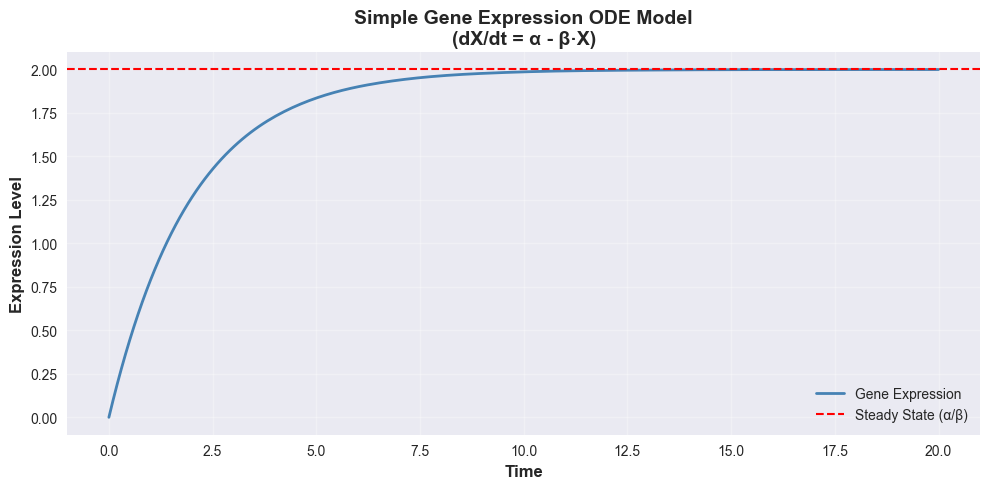

In [32]:
# Exercise 5: Synthetic Biology Mini-Model
print("=" * 60)
print("Exercise 5: Synthetic Biology Mini-Model in Python")
print("=" * 60)

# Part 1: Simple gene expression model
print("\n" + "=" * 60)
print("Part 1: Simple Gene Expression Model")
print("=" * 60)

# Simulate simple gene expression
df_simple = simulate_gene_ode(alpha=1.0, beta=0.5, t_end=20)

print(f"✓ Simulated gene expression for {len(df_simple)} time points")
print(f"  Final expression level: {df_simple['expression'].iloc[-1]:.3f}")
print(f"  Steady state (alpha/beta): {1.0/0.5:.3f}")

# Plot simple model
plt.figure(figsize=(10, 5))
plt.plot(df_simple['time'], df_simple['expression'], linewidth=2, color='steelblue', label='Gene Expression')
plt.axhline(y=1.0/0.5, color='red', linestyle='--', linewidth=1.5, label='Steady State (α/β)')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Expression Level", fontsize=12, fontweight='bold')
plt.title("Simple Gene Expression ODE Model\n(dX/dt = α - β·X)", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Part 2: Toggle Switch Circuit
✓ Simulated toggle switch for 500 time points
  Final X1 level: 1.000
  Final X2 level: 1.000


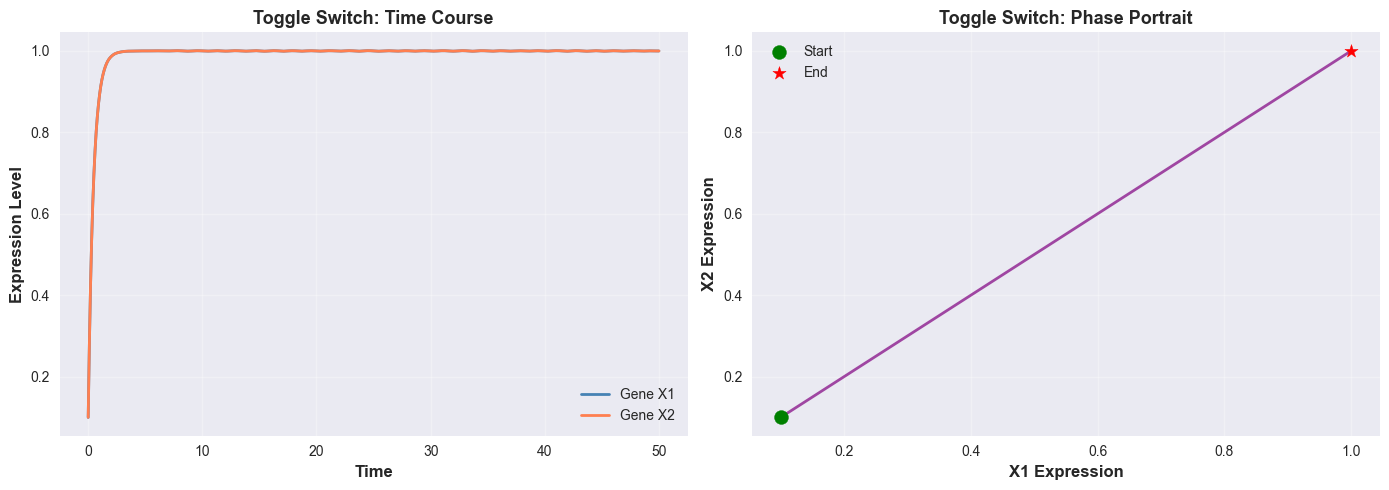


Toggle switch analysis:
  The circuit shows mutual repression between X1 and X2
  Final state: X1=1.000, X2=1.000
  → Circuit switched to X2-dominant state


In [33]:
# Part 2: Toggle Switch Circuit
print("\n" + "=" * 60)
print("Part 2: Toggle Switch Circuit")
print("=" * 60)

# Simulate toggle switch
df_toggle = simulate_toggle_switch(alpha1=2.0, alpha2=2.0, beta1=1.0, beta2=1.0,
                                   n=2, K=1.0, t_end=50, initial_conditions=[0.1, 0.1])

print(f"✓ Simulated toggle switch for {len(df_toggle)} time points")
print(f"  Final X1 level: {df_toggle['X1'].iloc[-1]:.3f}")
print(f"  Final X2 level: {df_toggle['X2'].iloc[-1]:.3f}")

# Plot toggle switch
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time course
ax1 = axes[0]
ax1.plot(df_toggle['time'], df_toggle['X1'], linewidth=2, color='steelblue', label='Gene X1')
ax1.plot(df_toggle['time'], df_toggle['X2'], linewidth=2, color='coral', label='Gene X2')
ax1.set_xlabel("Time", fontsize=12, fontweight='bold')
ax1.set_ylabel("Expression Level", fontsize=12, fontweight='bold')
ax1.set_title("Toggle Switch: Time Course", fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Phase portrait
ax2 = axes[1]
ax2.plot(df_toggle['X1'], df_toggle['X2'], linewidth=2, color='purple', alpha=0.7)
ax2.scatter([df_toggle['X1'].iloc[0]], [df_toggle['X2'].iloc[0]], 
           s=100, color='green', marker='o', label='Start', zorder=5)
ax2.scatter([df_toggle['X1'].iloc[-1]], [df_toggle['X2'].iloc[-1]], 
           s=100, color='red', marker='*', label='End', zorder=5)
ax2.set_xlabel("X1 Expression", fontsize=12, fontweight='bold')
ax2.set_ylabel("X2 Expression", fontsize=12, fontweight='bold')
ax2.set_title("Toggle Switch: Phase Portrait", fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nToggle switch analysis:")
print(f"  The circuit shows mutual repression between X1 and X2")
print(f"  Final state: X1={df_toggle['X1'].iloc[-1]:.3f}, X2={df_toggle['X2'].iloc[-1]:.3f}")
if df_toggle['X1'].iloc[-1] > df_toggle['X2'].iloc[-1]:
    print(f"  → Circuit switched to X1-dominant state")
else:
    print(f"  → Circuit switched to X2-dominant state")



Part 3: Activator Circuit (Positive Feedback)
✓ Simulated activator circuit (no knockdown) for 200 time points
  Final expression level: 0.000


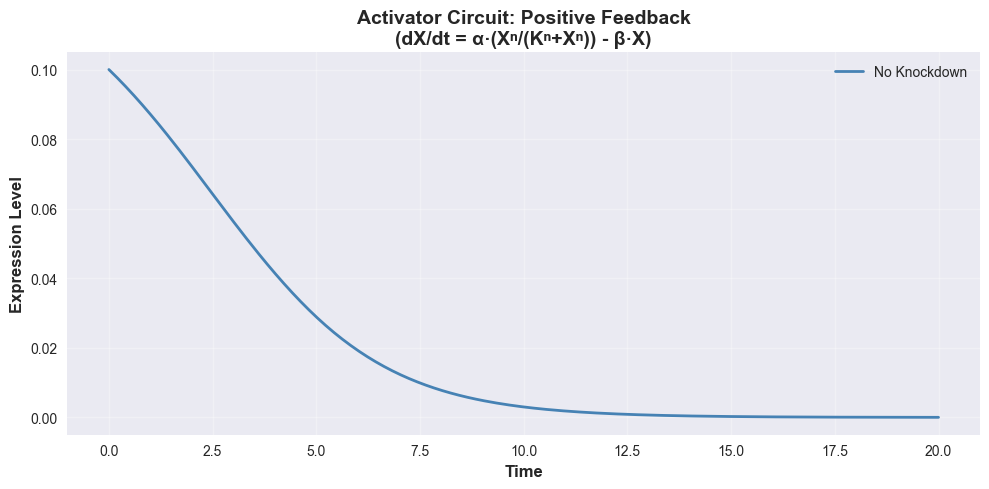


Activator circuit analysis:
  The gene activates its own expression (positive feedback)
  Final expression: 0.000


In [34]:
# Part 3: Activator Circuit (Positive Feedback)
print("\n" + "=" * 60)
print("Part 3: Activator Circuit (Positive Feedback)")
print("=" * 60)

# Simulate activator circuit without knockdown
df_activator_no_kd = simulate_activator_circuit(alpha=1.0, beta=0.5, n=2, K=0.5, 
                                                t_end=20, initial_condition=0.1, 
                                                knockdown_factor=1.0)

print(f"✓ Simulated activator circuit (no knockdown) for {len(df_activator_no_kd)} time points")
print(f"  Final expression level: {df_activator_no_kd['expression'].iloc[-1]:.3f}")

# Plot activator circuit
plt.figure(figsize=(10, 5))
plt.plot(df_activator_no_kd['time'], df_activator_no_kd['expression'], 
         linewidth=2, color='steelblue', label='No Knockdown')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Expression Level", fontsize=12, fontweight='bold')
plt.title("Activator Circuit: Positive Feedback\n(dX/dt = α·(Xⁿ/(Kⁿ+Xⁿ)) - β·X)", 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nActivator circuit analysis:")
print(f"  The gene activates its own expression (positive feedback)")
print(f"  Final expression: {df_activator_no_kd['expression'].iloc[-1]:.3f}")



Part 4: CRISPR-Mediated Knockdown Effect
Using top guide from Exercise 4:
  Guide sequence: AAAGTTGAACGCCTAGGCAG
  PAM position: 412
  Final score: 0.200

Simulating activator circuit with different knockdown strengths...
  No knockdown: Final expression = 0.000 (0.0% reduction)
  Mild (1.5x): Final expression = 0.000 (99.5% reduction)
  Moderate (2x): Final expression = 0.000 (99.8% reduction)
  Strong (3x): Final expression = 0.000 (98.2% reduction)
  Very Strong (5x): Final expression = 0.000 (97.5% reduction)


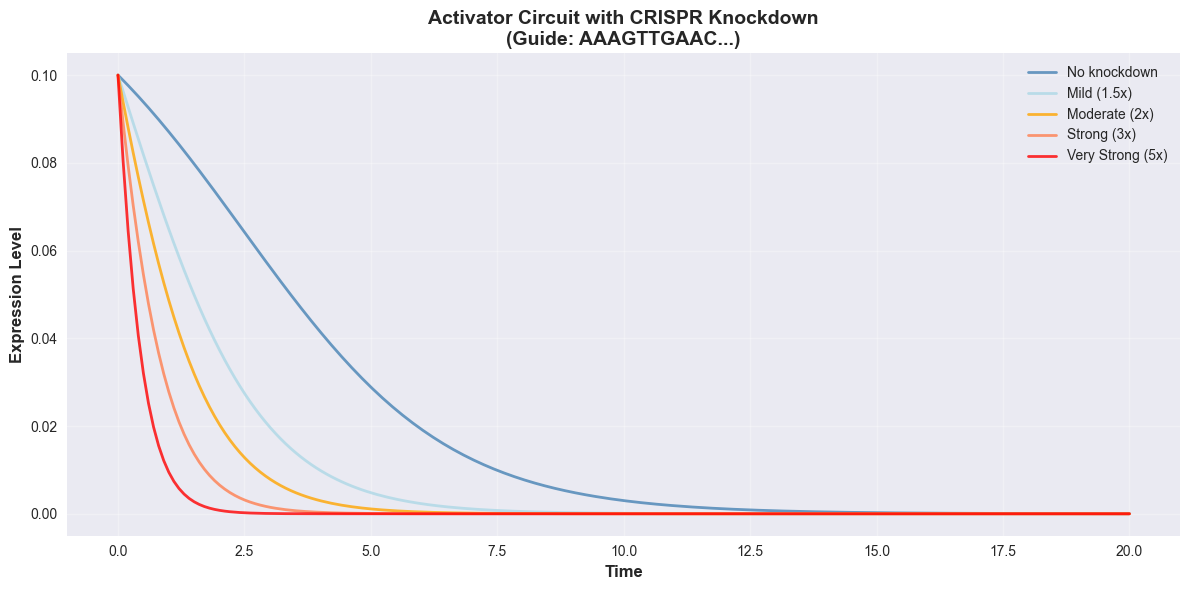


Knockdown Efficiency Analysis

Mild (1.5x) (factor=1.5):
  Final expression: 0.000 (baseline: 0.000)
  Knockdown efficiency: 99.5%

Moderate (2x) (factor=2.0):
  Final expression: 0.000 (baseline: 0.000)
  Knockdown efficiency: 99.8%

Strong (3x) (factor=3.0):
  Final expression: 0.000 (baseline: 0.000)
  Knockdown efficiency: 98.2%

Very Strong (5x) (factor=5.0):
  Final expression: 0.000 (baseline: 0.000)
  Knockdown efficiency: 97.5%


In [35]:
# Part 4: CRISPR Knockdown Effect
print("\n" + "=" * 60)
print("Part 4: CRISPR-Mediated Knockdown Effect")
print("=" * 60)

# Check if we have guides from Exercise 4
if 'df_guides' in locals() and df_guides is not None and len(df_guides) > 0:
    # Select a top guide for knockdown simulation
    top_guide = df_guides.iloc[0]
    print(f"Using top guide from Exercise 4:")
    print(f"  Guide sequence: {top_guide['guide']}")
    print(f"  PAM position: {top_guide['pam_start']}")
    print(f"  Final score: {top_guide.get('final_score', top_guide.get('combined_score', 'N/A')):.3f}")
    
    # Simulate different knockdown strengths
    # Knockdown factor: 1.0 = no effect, 2.0 = 2x degradation (50% knockdown), etc.
    knockdown_factors = [1.0, 1.5, 2.0, 3.0, 5.0]
    knockdown_labels = ['No knockdown', 'Mild (1.5x)', 'Moderate (2x)', 'Strong (3x)', 'Very Strong (5x)']
    
    print(f"\nSimulating activator circuit with different knockdown strengths...")
    
    # Simulate with different knockdown factors
    knockdown_results = {}
    for kd_factor, label in zip(knockdown_factors, knockdown_labels):
        df_kd = simulate_activator_circuit(alpha=1.0, beta=0.5, n=2, K=0.5,
                                          t_end=20, initial_condition=0.1,
                                          knockdown_factor=kd_factor)
        knockdown_results[label] = df_kd
        final_expr = df_kd['expression'].iloc[-1]
        reduction = (1 - final_expr / df_activator_no_kd['expression'].iloc[-1]) * 100
        print(f"  {label}: Final expression = {final_expr:.3f} ({reduction:.1f}% reduction)")
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    colors = ['steelblue', 'lightblue', 'orange', 'coral', 'red']
    
    for i, (label, df_kd) in enumerate(knockdown_results.items()):
        plt.plot(df_kd['time'], df_kd['expression'], linewidth=2, 
                color=colors[i], label=label, alpha=0.8)
    
    plt.xlabel("Time", fontsize=12, fontweight='bold')
    plt.ylabel("Expression Level", fontsize=12, fontweight='bold')
    plt.title(f"Activator Circuit with CRISPR Knockdown\n(Guide: {top_guide['guide'][:10]}...)", 
              fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate knockdown efficiency
    print(f"\n" + "=" * 60)
    print("Knockdown Efficiency Analysis")
    print("=" * 60)
    
    baseline_expr = df_activator_no_kd['expression'].iloc[-1]
    
    for label, df_kd in knockdown_results.items():
        if label != 'No knockdown':
            final_expr = df_kd['expression'].iloc[-1]
            reduction = (1 - final_expr / baseline_expr) * 100
            kd_factor = knockdown_factors[knockdown_labels.index(label)]
            print(f"\n{label} (factor={kd_factor}):")
            print(f"  Final expression: {final_expr:.3f} (baseline: {baseline_expr:.3f})")
            print(f"  Knockdown efficiency: {reduction:.1f}%")
    
else:
    print("⚠ Guides from Exercise 4 not found. Using default guide for demonstration.")
    
    # Simulate with default parameters
    knockdown_factors = [1.0, 2.0, 3.0, 5.0]
    knockdown_labels = ['No knockdown', 'Moderate (2x)', 'Strong (3x)', 'Very Strong (5x)']
    
    knockdown_results = {}
    for kd_factor, label in zip(knockdown_factors, knockdown_labels):
        df_kd = simulate_activator_circuit(alpha=1.0, beta=0.5, n=2, K=0.5,
                                          t_end=20, initial_condition=0.1,
                                          knockdown_factor=kd_factor)
        knockdown_results[label] = df_kd
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    colors = ['steelblue', 'orange', 'coral', 'red']
    
    for i, (label, df_kd) in enumerate(knockdown_results.items()):
        plt.plot(df_kd['time'], df_kd['expression'], linewidth=2, 
                color=colors[i], label=label, alpha=0.8)
    
    plt.xlabel("Time", fontsize=12, fontweight='bold')
    plt.ylabel("Expression Level", fontsize=12, fontweight='bold')
    plt.title("Activator Circuit with CRISPR Knockdown (Example)", 
              fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Demonstrated CRISPR knockdown effect on gene expression")


In [ ]:
# Summary visualization: All models together
print("\n" + "=" * 60)
print("Summary: Comparison of All Models")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Simple model
ax1 = axes[0, 0]
ax1.plot(df_simple['time'], df_simple['expression'], linewidth=2, color='steelblue')
ax1.axhline(y=1.0/0.5, color='red', linestyle='--', linewidth=1.5)
ax1.set_xlabel("Time", fontsize=11, fontweight='bold')
ax1.set_ylabel("Expression", fontsize=11, fontweight='bold')
ax1.set_title("Simple Model\n(dX/dt = α - β·X)", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Toggle switch
ax2 = axes[0, 1]
ax2.plot(df_toggle['time'], df_toggle['X1'], linewidth=2, color='steelblue', label='X1')
ax2.plot(df_toggle['time'], df_toggle['X2'], linewidth=2, color='coral', label='X2')
ax2.set_xlabel("Time", fontsize=11, fontweight='bold')
ax2.set_ylabel("Expression", fontsize=11, fontweight='bold')
ax2.set_title("Toggle Switch\n(Mutual Repression)", fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Activator (no knockdown)
ax3 = axes[1, 0]
ax3.plot(df_activator_no_kd['time'], df_activator_no_kd['expression'], 
         linewidth=2, color='steelblue', label='No Knockdown')
ax3.set_xlabel("Time", fontsize=11, fontweight='bold')
ax3.set_ylabel("Expression", fontsize=11, fontweight='bold')
ax3.set_title("Activator Circuit\n(Positive Feedback)", fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Knockdown comparison
ax4 = axes[1, 1]
if 'knockdown_results' in locals():
    colors = ['steelblue', 'lightblue', 'orange', 'coral', 'red']
    for i, (label, df_kd) in enumerate(knockdown_results.items()):
        if i < len(colors):
            ax4.plot(df_kd['time'], df_kd['expression'], linewidth=2, 
                    color=colors[i], label=label, alpha=0.8)
    ax4.set_xlabel("Time", fontsize=11, fontweight='bold')
    ax4.set_ylabel("Expression", fontsize=11, fontweight='bold')
    ax4.set_title("CRISPR Knockdown Effect", fontsize=12, fontweight='bold')
    ax4.legend(loc='best', fontsize=9)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Knockdown data\nnot available', 
            ha='center', va='center', fontsize=14, transform=ax4.transAxes)
    ax4.set_title("CRISPR Knockdown Effect", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Summary visualization complete")
print(f"\nKey Takeaways:")
print(f"  1. Simple model: Linear production and degradation → steady state")
print(f"  2. Toggle switch: Bistable system with two stable states")
print(f"  3. Activator circuit: Positive feedback → high expression")
print(f"  4. CRISPR knockdown: Increases degradation → reduces expression")
